In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import utils
import plotting
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import mplhep as hep
import vector

In [2]:
from ray import train, tune

In [3]:
#Load your dataset
samples = {
    "hh4b": ["GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8"],
    # "hh4b-c2p45": ["GluGlutoHHto4B_cHHH2p45_TuneCP5_PSWeights_13TeV-powheg-pythia8"],
    # "hh4b-c5": ["GluGlutoHHto4B_cHHH5_TuneCP5_PSWeights_13TeV-powheg-pythia8"],
    # "hh4b-c0": ["GluGlutoHHto4B_cHHH0_TuneCP5_PSWeights_13TeV-powheg-pythia8"],
    "qcd": [
        "QCD_HT-200to300-13TeV",
        "QCD_HT-300to500-13TeV",
        "QCD_HT-500to700-13TeV",
        "QCD_HT-700to1000-13TeV",
        "QCD_HT-1000to1500-13TeV",
        "QCD_HT-1500to2000-13TeV",
        "QCD_HT-2000toInf-13TeV",
    ],
    "ttbar": [
        "TTTo2L2Nu_13TeV",
        "TTToHadronic_13TeV",
        "TTToSemiLeptonic_13TeV",
        
    ],    
}

year = "2018"#
dir_name = "23Nov18_WSel_v9_private"
path_to_dir = f"/eos/uscms/store/user/cmantill/bbbb/matching/{dir_name}/"
dirs = {path_to_dir: samples}

filters = [
    [
        # one good fatjet (fatjet with index 0 has the largest Xbb score)
        ("('ak8FatJetPt', '0')", ">=", 300),
        ("('ak8FatJetMsd', '0')", ">=", 60),
        ("('ak8FatJetPNetXbb', '0')", ">=", 0.9734),  # medium WP
        # second fatjet has lower
        ("('ak8FatJetPNetXbb', '1')", "<", 0.9880),  # tight WP
    ]
]

# columns to load                                                                                                                                                                                                                                     
# the parquet files are too big so we can only load a few columns at a time without consumming much memory
load_columns = [
    ("weight", 1),
	("ak8FatJetMsd", 2),
    ("ak8FatJetPNetMass", 2),
	("ak8FatJetPNetXbb", 2),                                                                                                                                                                                                                     
]
# reformat into ("column name", "idx") format for reading multiindex columns                                                                                                                                                                          
columns = []
for key, num_columns in load_columns:
    for i in range(num_columns):
        columns.append(f"('{key}', '{i}')")


events_dict = {}
for input_dir, samples in dirs.items():
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **utils.load_samples(input_dir, samples, year, filters=filters),
    }

samples_loaded = list(events_dict.keys())
keys_loaded = list(events_dict[samples_loaded[0]].keys())
print(f"Keys in events_dict")
for i in keys_loaded:
    print(i)


# Assuming df has features and a binary target column named 'target'
#features = df.drop('target', axis=1)
#target = df['target']

Loading GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8
/eos/uscms/store/user/cmantill/bbbb/matching/23Nov18_WSel_v9_private//2018/GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8/parquet
Loading QCD_HT-1000to1500-13TeV
/eos/uscms/store/user/cmantill/bbbb/matching/23Nov18_WSel_v9_private//2018/QCD_HT-1000to1500-13TeV/parquet
Loading QCD_HT-1500to2000-13TeV
/eos/uscms/store/user/cmantill/bbbb/matching/23Nov18_WSel_v9_private//2018/QCD_HT-1500to2000-13TeV/parquet
Loading QCD_HT-2000toInf-13TeV
/eos/uscms/store/user/cmantill/bbbb/matching/23Nov18_WSel_v9_private//2018/QCD_HT-2000toInf-13TeV/parquet
Loading QCD_HT-200to300-13TeV
/eos/uscms/store/user/cmantill/bbbb/matching/23Nov18_WSel_v9_private//2018/QCD_HT-200to300-13TeV/parquet
Loading QCD_HT-300to500-13TeV
/eos/uscms/store/user/cmantill/bbbb/matching/23Nov18_WSel_v9_private//2018/QCD_HT-300to500-13TeV/parquet
Loading QCD_HT-500to700-13TeV
/eos/uscms/store/user/cmantill/bbbb/matching/23Nov18_WSel_v9_private//2018

In [5]:
import ray
ray.init()

2024-01-26 12:38:27,012	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.9.18
Ray version:,2.9.1


In [6]:
def make_vector(events: pd.DataFrame, obj: str):
    """Create a ``vector`` object from the columns of the dataframe"""
    mstring = "PNetMass" if obj == "ak8FatJet" else "Mass"

    return vector.array(
        {
            "pt": events[f"{obj}Pt"],
            "phi": events[f"{obj}Phi"],
            "eta": events[f"{obj}Eta"],
            "M": events[f"{obj}{mstring}"],
        }
    )

In [7]:
# DEFINE FEATURES & TARGET

# Higgs candidate selection example
events = pd.concat([events_dict["hh4b"], events_dict["qcd"], events_dict["ttbar"]], keys=['hh4b','qcd', 'ttbar'])

events['target'] = 0  #a|
# Default to 0 (background)
events.loc['hh4b', 'target'] = 1  # Set to 1 for 'hh4b' samples (signal)
multiIndex = events.index
events = events.reset_index()

/tmp/ipykernel_10452/2289044454.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  events.loc['hh4b', 'target'] = 1  # Set to 1 for 'hh4b' samples (signal)


MemoryError: Unable to allocate 1.32 GiB for an array with shape (352, 502802) and data type float64

In [ ]:
#print(events)

# jets outside the fatjet - sorted by b-score
jets_outside = make_vector(events, "ak4JetOutside")
# fatjets sorted by xbb
fatjets = make_vector(events, "ak8FatJet")

# H1 candidate
h1 = fatjets[:, 0]
h1_xbb = events.ak8FatJetPNetXbb[0]

# H2 candidate
# ak4 jet (outside) with highest b-tagging score (btagDeepFlavB)
j3 = jets_outside[:, 0]
j4 = jets_outside[:, 1]
j3_btag = events.ak4JetOutsidebtagDeepFlavB[0] # could use PNet b scores
j4_btag = events.ak4JetOutsidebtagDeepFlavB[1]
h2 = j3 + j4
hh = h1 + h2

# Second fatjet
fj2 = fatjets[:, 1]
fj2_xbb = events.ak8FatJetPNetXbb[1]



df = pd.DataFrame()




#df['ak4JetOutsideEta'] = events_dict['ak4GenJetEta', 0]
#df['ak8FatJetPNetMass'] = events.ak8FatJetPNetMass[0]

#df['h1_xbb'] = h1_xbb# to have more handles for further discrimination and better calibration 
df['logPtHH'] = np.log(hh.pt)#
df['logPtH1'] = np.log(h1.pt)#
df['logPtJ3'] = np.log(j3.pt)#
df['logPtJ4'] = np.log(j4.pt)#
df['H1Pt_H2Pt'] = h1.pt/h2.pt#
df['dPhiJ3J4'] = j3.deltaphi(j4)
df['dRJ3J4'] = j3.deltaR(j4)#
df['j3_btag'] = j3_btag#
df['j4_btag'] = j4_btag#
df['j3_j4_ratio'] = j3.pt/j4.pt#
df['hb_eta'] = h1.eta#
#df['hb_mass'] = h1.mass# better resolution
df['hr_pt'] = h2.pt#
df['hr_eta'] = h2.eta#
df['hr_mass'] = h2.mass# 
hh.eta[np.isinf(hh.eta)] = 10000
df['HHEta'] = hh.eta#  # this triggers invalid value exception due to inf values
df['HHMass'] = hh.M#
df['fj2_pt'] = fj2.pt#
df['fj2_eta'] = fj2.eta#
df['fj2_mass'] = fj2.M#
df['fj2_btag'] = fj2_xbb#
drh1h2 = np.sqrt((h1.eta-h2.eta)**2 + (h1.phi - h2.phi)**2)
drh1h2[np.isinf(drh1h2)] = 10000
df['dRH1H2'] = drh1h2#
df['dphi'] = h1.deltaphi(h2)#
df['deta'] = h1.deltaeta(h2)#

df.replace(np.inf, 10000, inplace=True)
df.replace(-np.inf, 10000, inplace=True)

In [ ]:
#LOAD FEATURES INTO PD DF
features = df.set_index(multiIndex)

#define target
target = events['target']

In [8]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [9]:
# Initialize the BDT model
bdt_model = XGBClassifier(
    n_estimators= 196,
    max_depth= 17,
    learning_rate=0.1,
    subsample=0.5,
    random_state=42
)



In [10]:
# Train the model
bdt_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=196, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [11]:
# Make predictions
predictions = bdt_model.predict(X_test)


In [12]:
# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)

In [13]:
print(roc_auc)


0.642502104675623


In [14]:
print(predictions)

[0 0 0 ... 0 0 0]


In [15]:
probabilities = bdt_model.predict_proba(X_test)

print(probabilities[:,0])

[0.99983186 0.99471074 0.9845837  ... 0.9998878  0.9980431  0.9986171 ]


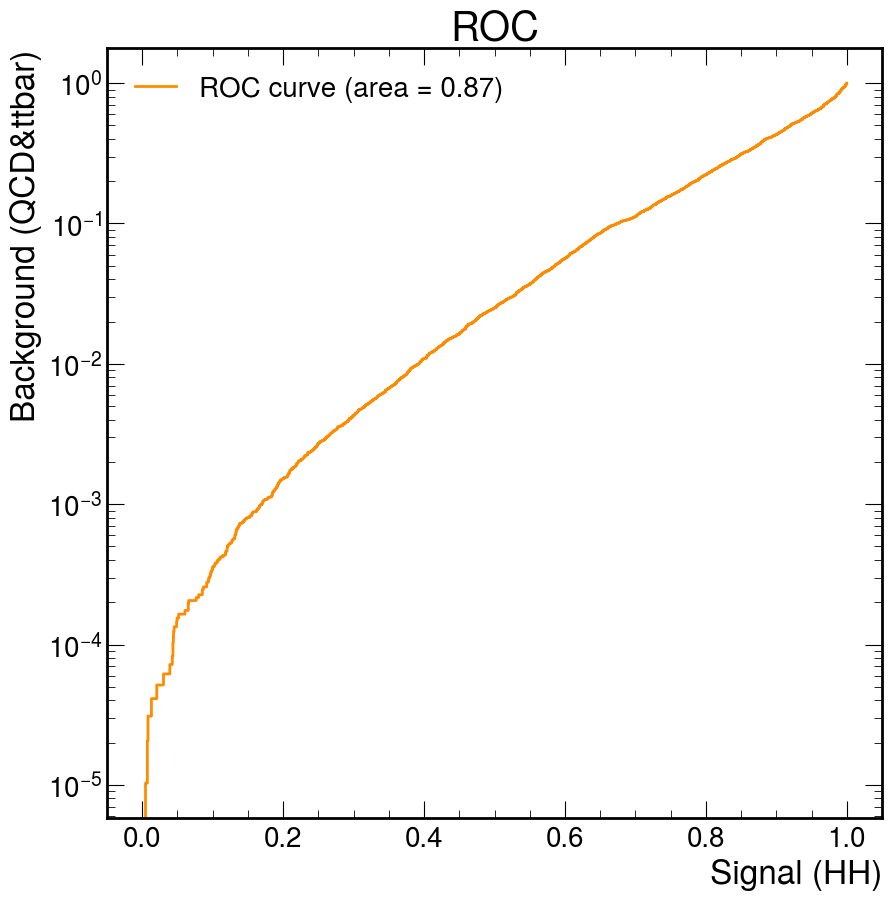

In [16]:
y_scores = bdt_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

#histogram for y scores signal & background 
#rank by importance

#number of b-jets that can be identified in resolved
#another feather cos(theta_star)

#Plottting
plt.figure()
plt.plot(tpr, fpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('Signal (HH)')
plt.ylabel('Background (QCD&ttbar)')
plt.title('ROC')
plt.legend(loc="upper left")
plt.yscale('log')
plt.show()


In [19]:
!pip install xgboost_ray

  Obtaining dependency information for xgboost_ray from https://files.pythonhosted.org/packages/46/d2/49b8f3617c2b760cf30e334ba6791b3f646c0bc4eee389bb4a7d2b8ee3ae/xgboost_ray-0.1.19-py3-none-any.whl.metadata
  Obtaining dependency information for wrapt>=1.12.1 from https://files.pythonhosted.org/packages/b1/e7/459a8a4f40f2fa65eb73cb3f339e6d152957932516d18d0e996c7ae2d7ae/wrapt-1.16.0-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 1.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 1.1 MB/s eta 0:00:00a 0:00:01


In [23]:
from xgboost_ray import RayXGBClassifier

def train_HH4b(config):
    bdt_model = RayXGBClassifier(
        n_jobs=1,
        random_state=42,
        **config
    )
    bdt_model.fit(X_train, y_train)
    
    y_scores = bdt_model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    return {"roc_auc": roc_auc}

In [24]:
config = {
    "n_estimators": tune.randint(190, 200),
    "max_depth": tune.randint(10, 20),
    "learning_rate": tune.uniform(1e-1, 1e-3),
    "subsample": tune.uniform(0.5, 0.8),
}
tuner = tune.Tuner(
    train_HH4b,
    param_space=config
)
results = tuner.fit()

ValueError: Tracked actor is not managed by this event manager: <TrackedActor 124344823799451146582805344405211070143>

In [ ]:
#determine importance of the features

importances = bdt_model.feature_importances_

feature_names = df.columns
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

for feature in feature_importance:
    print(f"{feature[0]}: {feature[1]:.3f}")


In [ ]:
hh4b_scores = bdt_model.predict_proba(X_test.loc['hh4b'])[:, 1]
qcd_scores = bdt_model.predict_proba(X_test.loc['qcd'])[:, 1]
ttbar_scores = bdt_model.predict_proba(X_test.loc['ttbar'])[:, 1]

In [ ]:
plt.figure()
plt.hist(hh4b_scores, bins=40, histtype='step', linewidth=1.5, color='darkblue')
plt.hist(qcd_scores, bins=40, histtype='step', linewidth=1.5, color='red')
plt.hist(ttbar_scores, bins=40, histtype='step', linewidth=1.5, color='darkgreen')
plt.legend(['hh4b', 'qcd', 'ttbar'])
plt.ylabel('Frequency')
plt.xlabel('Prediciton Score')
plt.title('Model Predictions Histogram')
plt.yscale('log')
plt.show()
